In [1]:
import pandas as pd
from pathlib import Path
path = Path('/mnt/research-live/equity/reference/equity_data/sa_research/current/')
import pandas as pd 
import numpy as np 
import faiss 
import re
import tqdm
import torch 
import torch.nn.functional as F
import dill as pickle
import datetime
import plotly.express as px
from laserembeddings import Laser
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import copy
import math
from scipy.signal import find_peaks
import seaborn as sns
from pandas.tseries.offsets import BDay
from sklearn.metrics import silhouette_score
from sklearn import metrics
from time import time
from sklearn.cluster import KMeans

/home/yzhong/conda/envs/yihan_gpu/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def is_blank_string(value):
    return value.strip() == ''

In [17]:
import nltk
import wordcloud
from collections import Counter
def top_common_words(earning_no_capital,col,most_common):

    # Get the stop words
    stopwords = set(wordcloud.STOPWORDS)
    stopwords.update(["br", "href"])

    # Create a list to store the words
    words = []
    if col=='body':
        df=earning_no_capital[~earning_no_capital['body'].apply(is_blank_string)]['body']
    if col=='headline':
        df=earning_no_capital['headline'].dropna()

    # Iterate over the "body" column and tokenize the text
    for text in df:
        tokens = nltk.word_tokenize(text.lower())
        # Filter out stop words and non-alphabetic words
        words += [word for word in tokens if word.isalpha() and word not in stopwords]

    # Count the frequency of words
    word_counts = Counter(words)

    # Get the top 10 most frequent words
    top_words = word_counts.most_common(most_common)

    # Print the top 10 words and their frequencies
    for word, count in top_words:
        print(f"{word}: {count}")
        
    return top_words

In [3]:
from pathlib import Path
path = Path('/mnt/research-live/equity/reference/equity_data/sa_research/current/')
ead_ = pd.read_parquet(path /'CFM_AMER/equity_data/eqt_earning_announcement_dates.parquet') # date for earnings
news_volume_ =pd.read_parquet(path /'CFM_AMER/equity_data/eqt_bb_news_volumes.parquet') # volume for each date
news_company=pd.read_parquet('/mnt/research-live/user/yzhong/bloomberg_news_english_single_stock.parquet')

In [4]:
news_company['date']=pd.to_datetime(news_company['date'])

In [5]:
filtered_df = news_company.merge(ead_, left_on=['eqt_code', 'date'], right_on=['eqt_code', 'earning_date'], how='inner')

## Creating regex expression

In [ ]:
top_common_words(filtered_df,'headline',30)

In [6]:
def filter_balance_sheet(df, col='headline'):
    pattern = r"(?=.*?\b(?:CAPEX|CAPITAL|EPS|NET|INCOME|REV|INC|LOSS|BILLINGS|ADJ|SALES|EQUITY|ENTITLEMENT|COSTS|REVENUE|ADJUSTED|PROFIT|EST|EARNINGS|INCOME|CASH|EPA)\b)"

    # Apply filter conditions and add flag column
    df['balance_sheet'] = (
        df[col].apply(lambda headline: bool(re.search(pattern, headline)))
        & ~df[col].apply(lambda headline: bool(re.match(r"^\D*\b\dQ\b\D*$", headline)))
        & ~df[col].apply(lambda headline: bool(re.match(r"^\D*(?:20(?:0[8-9]|1\d|20|23))\D*$", headline)))
        & df[col].str.contains(r'\d')
    ).astype(int)

    return df

In [7]:
df=filter_balance_sheet(filtered_df, col='headline')

In [8]:
df

,suid,last_update,eqt_code,analyst,date,daclose,headline,body,earning_date,balance_sheet
0,K9QU086JIJUO,2008-11-03 06:00:08.530,TRL_UN,False,2008-11-03,2008-11-03,DAVITA 3Q EPS 89C.,PR Newswire: U.S. press release is accessible ...,2008-11-03,1
1,K9QU3P0D9L4G,2008-11-03 06:02:13.890,TRL_UN,False,2008-11-03,2008-11-03,DAVITA 3Q NET $93.9 MLN.,PR Newswire: U.S. press release is accessible ...,2008-11-03,1
2,K9QU4U0D9L3Q,2008-11-03 06:02:54.570,TRL_UN,False,2008-11-03,2008-11-03,DAVITA SEES 2008 OP. PROFIT NEAR MIDDLE OF PRE...,PR Newswire: U.S. press release is accessible ...,2008-11-03,0
3,K9QV121A1I4I,2008-11-03 06:22:14.950,TRL_UN,False,2008-11-03,2008-11-03,DaVita Profit Falls After One-Time Gains in Qu...,"DaVita Inc., the second-largest U.S.operator o...",2008-11-03,0
4,K9RQLO1A74E9,2008-11-03 17:44:12.690,TRL_UN,False,2008-11-03,2008-11-03,DaVita Profit Falls After One-Time Gain Year E...,Adds analysts' estimates in the second paragra...,2008-11-03,0
...,...,...,...,...,...,...,...,...,...,...
725420,RU5LRT6RV5E3,2023-05-04 21:45:29.952,BRPR3_BS,False,2023-05-04,2023-05-04,"BR PROPERTIES 1Q ADJ. EBITDA R$13.1M, -76% Y/Y.",,2023-05-04,1
725421,RU5MG06RV5E8,2023-05-04 22:00:00.601,SIMO_US,False,2023-05-04,2023-05-04,"SILICON MOTION 1Q ADJ EARNINGS PER ADS 33C, ES...",,2023-05-04,1
725422,RU5MG06RV5E9,2023-05-04 22:00:00.615,SIMO_US,False,2023-05-04,2023-05-04,"SILICON MOTION 1Q REV. $124.1M, EST. $167.6M.",,2023-05-04,1
725423,RU5MG16RV5DS,2023-05-04 22:00:02.824,SIMO_US,False,2023-05-04,2023-05-04,Silicon Motion 1Q Adj Earnings per ADS Misses ...,Silicon Motion reported adjusted earningsper A...,2023-05-04,0


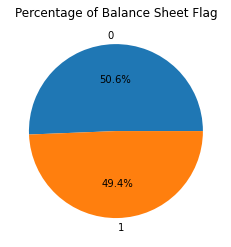

In [100]:


def plot_balance_sheet(df):
    # Calculate the percentage of balance_sheet values
    percentages = df['balance_sheet'].value_counts(normalize=True) * 100

    # Create the pie plot
    labels = ['0', '1']
    plt.pie(percentages, labels=labels, autopct='%1.1f%%')

    # Add title
    plt.title('Percentage of Balance Sheet Flag')

    # Show the plot
    plt.show()

# Example usage
plot_balance_sheet(df)



now, remove duplicates and calculate again

In [101]:
with open('/mnt/research-live/user/yzhong/earning.txt', 'w') as f:
    for row in df.itertuples():
        f.write(str(row.headline) + '\n')
        f.write(str(row.balance_sheet) + '\n')

## The regex expression is wrong because it makes the sentences needs to add a condition to make sure that the sentence contains at least one digits .

In [12]:
import re

# Example news headlines
headlines = [
    "SILICON MOTION 1Q ADJ EARNINGS PER ADS 33C, EST. 70C.",
    "SILICON MOTION 1Q REV. Slow",
    "SILICON MOTION EARNINGS PER ",
    "SILICON MOTION 2020 REV. Slow",
    "ENERPLUS 1Q  ADJ. $140.7M, $134M.",
    "MASTEC SEES 2Q REV. $3.0B, EST. $3.09B.",
    "FORTINET SEES 2Q REV. $1.28B TO $1.32B, EST. $1.28B.",
    "JAMF HOLDING SEES FY ADJ. OPER INCOME $41.0M TO $43.0M.",
    "FIRSTENERGY NOW SEES YEAR ADJUSTED EPS $4.30-$4.40.",
    "2022 NET INCOME $1.5B.",
    "2020 CAPITAL EXPENDITURE $500M.",
    "REVENUE GROWTH EST. 10%.",
]

# Regex pattern
pattern = r"(?=.*?\b(?:CAPEX|CAPITAL|EPS|NET|INCOME|REV|INC|LOSS|BILLINGS|ADJ|SALES|REVENUE|ADJUSTED|PROFIT|EST|EARNINGS|INCOME|CASH EPA)\b)"

# Filter headlines
filtered_headlines = [
    headline
    for headline in headlines
    if re.search(pattern, headline)
    and not re.match(r"^\D*\b\dQ\b\D*$", headline)
    and not re.match(r"^\D*(?:20(?:0[8-9]|1\d|20|23))\D*$", headline)
]

# Print filtered headlines
for headline in filtered_headlines:
    print(headline)

SILICON MOTION 1Q ADJ EARNINGS PER ADS 33C, EST. 70C.
SILICON MOTION EARNINGS PER 
ENERPLUS 1Q  ADJ. $140.7M, $134M.
MASTEC SEES 2Q REV. $3.0B, EST. $3.09B.
FORTINET SEES 2Q REV. $1.28B TO $1.32B, EST. $1.28B.
JAMF HOLDING SEES FY ADJ. OPER INCOME $41.0M TO $43.0M.
FIRSTENERGY NOW SEES YEAR ADJUSTED EPS $4.30-$4.40.
2022 NET INCOME $1.5B.
2020 CAPITAL EXPENDITURE $500M.
REVENUE GROWTH EST. 10%.


In [20]:
import re

headlines = [
    "Financial results for 2012",
    "Q4 earnings announcement",
    "Sales update for 2022 on 5,00",
    "Revenue forecast for 2023"
]

filtered_headlines = [
    headline
    for headline in headlines
    if not re.match(r"^\D*(?:20(?:0[8-9]|1\d|20|21|22|23))\D*$", headline)
]

print(filtered_headlines)


['Q4 earnings announcement', 'Sales update for 2022 on 5,00']


In [24]:
import re

headlines = [
    "Financial results for 2012 is up to 200 dollars",
    "Q4 earnings announcement i",
    "Sales update for 2022 on 5,00",
    "Revenue forecast for 2055"
]

filtered_headlines = [
    headline
    for headline in headlines
    if not re.match(r"^\D*(?:(19|[2-9][0-9])\d{2})\D*$", headline)
]


print(filtered_headlines)

['Financial results for 2012 is up to 200 dollars', 'Q4 earnings announcement i', 'Sales update for 2022 on 5,00']


In [10]:
len(filtered_df)/len(news_company)

0.05124285060073355

In [235]:
def identify_market_on_close(headline):
    pattern = r'^MARKET ON CLOSE.*'
    return re.match(pattern, headline) is not None

In [236]:
def is_all_uppercase(headline):
    # Remove any non-alphabet characters from the headline
    headline_alpha = re.sub(r'[^A-Za-z]', '', headline)
    return headline_alpha.isupper()

Deduplications

In [237]:
import copy

def find_duplicates(df):
    df_copy = copy.deepcopy(df)
    df_copy['headline_lower'] = df_copy['headline'].str.lower()  # Convert headlines to lowercase
    regex_pattern =r'correct:|\(\d+\)\.|update\d+|\(correct\)'
    duplicates = df_copy[df_copy.duplicated(subset='headline_lower', keep='first') | df_copy['headline_lower'].str.contains(regex_pattern)]
    return duplicates.index.tolist()

In [221]:
from itertools import combinations

# Extract the topics from the 'topics' column and split them into lists
topics_lists = filtered_df['topics'].str.split(' ').tolist()

# Create a dictionary to store the indices for each unique topic set
topic_indices = {}

# Find rows with the same topics
for i, j in combinations(range(len(topics_lists)), 2):
    if set(topics_lists[i]) == set(topics_lists[j]):
        topic_set = tuple(sorted(set(topics_lists[i])))
        if topic_set in topic_indices:
            topic_indices[topic_set].add(i)
            topic_indices[topic_set].add(j)
        else:
            topic_indices[topic_set] = {i, j}

# Print the indices of rows with the same topics
for indices in topic_indices.values():
    print(list(indices))

[1, 34, 3, 4, 6, 8, 9, 28, 29]
[32, 5]
[10, 77]
[11, 36, 37, 71]
[12, 13]
[40, 15]
[70, 39, 72, 73, 42, 75, 45, 46, 47, 16, 17, 18, 19, 48, 82, 22, 84]
[24, 64, 63, 23]
[25, 61]
[27, 54]
[67, 69, 57, 59, 60, 30, 31]
[81, 44]
[50, 51]
[56, 55]


In [105]:
filtered_df[filtered_df.index.isin([24, 64, 63, 23,27, 54,25, 61])]

,suid,last_update,eqt_code,analyst,date,daclose,topics,headline,body
23,RB0SWET0AFB7,2022-04-28 11:00:00.212,MCD_UN,False,2022-04-28,2022-04-28,BIZNEWS MSCIWORLD NORTHAM CONSD ERN ACEXCLUDE ...,"MCDONALD'S 1Q ADJ EPS $2.28, EST. $2.17.",
24,RB0SYBT0AFBB,2022-04-28 11:00:00.214,MCD_UN,False,2022-04-28,2022-04-28,BIZNEWS MSCIWORLD NORTHAM CONSD ERN ACEXCLUDE ...,"MCDONALD'S 1Q REV. $5.67B, EST. $5.57B.",
25,RB1MZ8DWX2PU,2022-04-28 11:00:00.252,MCD_UN,False,2022-04-28,2022-04-28,METALKEY ALLHOT BIZNEWS MSCIWORLD NORTHAM GLOB...,"MCDONALD'S 1Q COMP SALES +11.8%, EST. +8.73%.",
27,RB0SZBT0AFB6,2022-04-28 11:00:00.253,MCD_UN,False,2022-04-28,2022-04-28,BIZNEWS MSCIWORLD NORTHAM CONSD ERN ACEXCLUDE ...,"MCDONALD'S 1Q US COMP SALES +3.5%, EST. +3.59%.",
54,RFMJX0DWX2PW,2022-07-26 11:00:36.939,MCD_UN,False,2022-07-26,2022-07-26,BIZNEWS MSCIWORLD NORTHAM CONSD ERN ACEXCLUDE ...,"MCDONALD'S 2Q US COMP SALES +3.7%, EST. +2.98%.",
61,RFMK6CBZ8CG0,2022-07-26 11:06:12.985,MCD_UN,False,2022-07-26,2022-07-26,EDGWEB BIZNEWS MSCIWORLD NORTHAM CONSD ACEXCLU...,MCDONALD'S SEES YEAR INTEREST EXPENSE RELATIVE...,
63,RKEO7UDWX2PW,2022-10-27 11:00:00.201,MCD_UN,False,2022-10-27,2022-10-27,BIZNEWS MSCIWORLD NORTHAM CONSD ERN ACEXCLUDE ...,"MCDONALD'S 3Q US COMP SALES +6.1%, EST. +3.7%.",
64,RKDOHDDWX2PT,2022-10-27 11:00:07.305,MCD_UN,False,2022-10-27,2022-10-27,BIZNEWS MSCIWORLD NORTHAM CONSD ERN ACEXCLUDE ...,"MCDONALD'S 3Q ADJ EPS $2.68, EST. $2.57.",


Check the topics that exist in all the news
ACEXCLUDE: excluded from alert catcher -- the news of capital letter 

In [222]:
# Extract the topics from the 'topics' column and split them into lists
topics_lists = filtered_df['topics'].str.split(' ').tolist()

# Find the intersection of topics across all news articles
common_topics = set(topics_lists[0]).intersection(*topics_lists)

# Print the common topics
print("Topics present in all news articles:")
for topic in common_topics:
    print(topic)

Topics present in all news articles:
ACEXCLUDE
G10MEMB
NORTHAM
USMW
MSCIWORLD
MISC
US
RES
SPREGIONS
BIZNEWS
CONSD
BGOVCODES
COS
IL
BGOVBILLGO
SRCRANK1
WORLD
HEADS
PADD2
DEVECO
ALLSTATES
GAMLODRES
CONS
PADDIST
MSCINAMER
EQUITYKEY
G7MEMB
BUSINESS
BONDWIRES
INDUSTRIES


In [223]:
len(common_topics)

30

The percentage of all the other tags

In [224]:
from collections import Counter

# Extract the topics from the 'topics' column and split them into lists
topics_lists = filtered_df['topics'].str.split(' ').tolist()

# Find the intersection of topics across all news articles
common_topics = set(topics_lists[0]).intersection(*topics_lists)

# Remove common topics from topics_lists
topics_lists_without_common = [list(set(topics) - common_topics) for topics in topics_lists]

# Flatten the topics_lists_without_common into a single list
all_topics = [topic for topics in topics_lists_without_common for topic in topics]

# Calculate the percentage of each topic that exists in all news articles
topic_counts = Counter(all_topics)
total_news = len(topics_lists)
topic_percentages = {topic: (count / total_news) * 100 for topic, count in topic_counts.items()}
# Filter out topics with a percentage count less than 5%
filtered_topics = [topic for topic, percentage in topic_percentages.items() if percentage < 5]
# Sort the topics by percentage in descending order
sorted_topics = sorted(topic_percentages.items(), key=lambda x: x[1], reverse=True)

# Print the sorted topics and their percentages
print("Topic\t\tPercentage")
for topic, percentage in sorted_topics:
    print(f"{topic}\t\t{percentage:.2f}%")

Topic		Percentage
FINNEWS		97.65%
ERN		71.76%
RIF		57.65%
HOU		51.76%
CONSS		51.76%
FOD		51.76%
RET		51.76%
RLSHEAD		31.76%
CPNYCNT1		18.82%
EDG		14.12%
FILINGS		14.12%
EDGWEB		14.12%
CFDOCS		14.12%
EDGSDR		14.12%
DEBTKEY		12.94%
RATESKEY		12.94%
FXKEY		12.94%
CREDITKEY		12.94%
CMDKEY		11.76%
ECO		11.76%
CMP		10.59%
INF		9.41%
FIALL		9.41%
ECOINDIC		9.41%
FIASST		9.41%
ECOSTAT		9.41%
CMD		7.06%
CMPPUB		7.06%
GUIDANCE		7.06%
MARKETS		5.88%
EQTY		5.88%
NRGKEY		5.88%
METALKEY		5.88%
CMDMISC		5.88%
CMDX		5.88%
BFWEQ		4.71%
FIRSTWORD		4.71%
INMONEY		3.53%
MAJOR		3.53%
RUNEWS		3.53%
TOP		3.53%
OILKEY		3.53%
ALLHOT		3.53%
INEQUITY		3.53%
MTGEKEY		3.53%
CMDGLOMAC		3.53%
REGIONFILT		3.53%
BROKERLITE		3.53%
TIMECO		3.53%
GLOBALMACR		3.53%
HOT		3.53%
TIMENI		3.53%
AGRKEY		3.53%
POLIRISK		3.53%
GOV		3.53%
LIFESTYLE		3.53%
GDRESTS		3.53%
DINE		3.53%
NASIA		3.53%
ASIAX		3.53%
EXUSSR		3.53%
CMPAUTO		3.53%
HEADGEN		3.53%
BFWUS		2.35%
FIXTURE		2.35%
STKMOV		2.35%
STK		2.35%
ALLMOV		2.35%
BFWFOCUS		2.35

Topic tags, which percentage is less than 5%

In [185]:
print(filtered_topics)


['SSSALES', 'COEVNT', 'BFWEQ', 'FIRSTWORD', 'BFWUS', 'BB', 'MAJOR', 'RUNEWS', 'TOP', 'OILKEY', 'BRNEWS', 'ALLHOT', 'MTGEKEY', 'CMDKEY', 'RATESKEY', 'CMDGLOMAC', 'FXKEY', 'REGIONFILT', 'TIMECO', 'GLOBALMACR', 'MARKETS', 'HOT', 'TIMENI', 'AGRKEY', 'NRGKEY', 'METALKEY', 'BRIC', 'ASIA', 'ESGRES', 'CHINA', 'SUPPLYDISR', 'ESGCONTROV', 'MSCIEMAS', 'NASIA', 'SUPPLY', 'EM', 'ASIAX', 'FRX', 'LIFESTYLE', 'GDRESTS', 'GEN', 'DINE', 'RESTOPEN', 'NOB', 'COR', 'DRA', 'BON', 'CRA', 'FIASST', 'FISUB', 'CORPFIN', 'DIRECTHEAD', 'CBM', 'FIALL', 'BFWTOPFEED', 'TOPBFW', 'ANAESTCHG', 'ANAMOVES', 'ANA', 'ANAESTDOWN', 'CHARGES', 'ANAESTUP', 'TAX', 'POLIRISK', 'GOV', 'BBK', 'CACT', 'STK', 'TNM', 'POSPRE', 'BFW', 'MET', 'CMD', 'BASIC', 'METMNG', 'METSTAT', 'CMDX', 'COMSTAT']


In [186]:
un_meaningful_tags=['FINNEWS','RLSHEAD','ALLSTATES','CPNYCNT1','CMP']

The headline that contains topic tags of a certain threshold 

In [61]:
def create_small_dataframe(df, percentage_low,percentage_up):
    # Sort the topics by percentage in descending order
    sorted_topics = sorted(topic_percentages.items(), key=lambda x: x[1], reverse=True)

    # Create an empty dictionary to store the news headlines and their corresponding topic tags
    small_df_data = {}

    # Iterate over the topics and percentages
    for topic, percentage in sorted_topics:
        # Check if the percentage is less than the threshold
        if percentage_low<percentage < percentage_up:
            # Iterate over the rows of the input dataframe
            for index, row in df.iterrows():
                headline = row['headline']
                topics = row['topics'].split(' ')
                # Check if the topic is in the list of topics for the current row
                if topic in topics:
                    if headline not in small_df_data:
                        small_df_data[headline] = [topic]
                    else:
                        small_df_data[headline].append(topic)

    # Create a list of tuples with the headline and list of topics
    small_df_data_tuples = [(headline, topics) for headline, topics in small_df_data.items()]

    # Create the small dataframe
    small_df = pd.DataFrame(small_df_data_tuples, columns=['headline', 'topics'])

    return small_df


In [115]:
create_small_dataframe(filtered_df, 3,4)

,headline,topics
0,"MCDONALD'S 4Q COMP SALES +12.3%, EST. +10.7%.","[INMONEY, MAJOR, RUNEWS, TOP, OILKEY, ALLHOT, ..."
1,"MCDONALD'S 1Q COMP SALES +11.8%, EST. +8.73%.","[INMONEY, MAJOR, RUNEWS, TOP, OILKEY, ALLHOT, ..."
2,"MCDONALD'S 3Q COMP SALES +9.5%, EST. +5.8%.","[INMONEY, MAJOR, RUNEWS, TOP, OILKEY, ALLHOT, ..."
3,MCDONALD'S SEES YR EFFECTIVE INCOME TAX RATE I...,"[POLIRISK, GOV]"
4,MCD: CHINA 4Q RESULTS HURT BY GOVERNMENT COVID...,"[POLIRISK, GOV, NASIA, ASIAX]"
5,MCD: SEE YR EFFECTIVE TAX RATE 20% TO 22% RANGE.,"[POLIRISK, GOV]"
6,"MCDONALD'S SEES OPENING OVER 1,800 RESTAURANTS...","[LIFESTYLE, GDRESTS, DINE]"
7,"MCD: SEE OPENING ~1,700-1,800 RESTAURANTS GLOB...","[LIFESTYLE, GDRESTS, DINE]"
8,"MCDONALD'S SEES OPENING ~1,700 RESTAURANTS GLO...","[LIFESTYLE, GDRESTS, DINE]"
9,MCDONALD'S: SOME STORES IN CHINA STILL CLOSED ...,"[NASIA, ASIAX]"


In [62]:
def excluded_tag(df, excluded_topic):
    # Create an empty dictionary to store the news headlines and their corresponding topic tags
    small_df_data = {}

    # Iterate over the rows of the input dataframe
    for index, row in df.iterrows():
        headline = row['headline']
        topics = row['topics'].split(' ')
        # Check if the excluded topic is not in the list of topics for the current row
        if excluded_topic not in topics:
            if headline not in small_df_data:
                small_df_data[headline] = topics
            else:
                small_df_data[headline].extend(topics)

    # Create a list of tuples with the headline and list of topics
    small_df_data_tuples = [(headline, topics) for headline, topics in small_df_data.items()]

    # Create the small dataframe
    small_df = pd.DataFrame(small_df_data_tuples, columns=['headline', 'topics'])

    return small_df


In [51]:
excluded_tag(filtered_df, 'FINNEWS')

,headline,topics
0,MCDONALD'S 2Q GLOBAL SAME-STORE SALES DOWN 0.7%.,"[ACEXCLUDE, BGOVBILLGO, BIZNEWS, BONDWIRES, CM..."
1,MCDONALD'S 2Q U.S. SAME-STORE SALES DOWN 2%.,"[ACEXCLUDE, BGOVBILLGO, BIZNEWS, BONDWIRES, CM..."
2,MCDONALD'S 2Q REV. $6.50B.,"[ACEXCLUDE, BGOVBILLGO, BIZNEWS, BONDWIRES, CM..."
3,MCDONALD'S 2Q EPS $1.26.,"[ACEXCLUDE, BGOVBILLGO, BIZNEWS, BONDWIRES, CM..."
4,MCDONALD'S 2Q REV. $6.50B EST. $6.43B.,"[ACEXCLUDE, BGOVBILLGO, BIZNEWS, BONDWIRES, CM..."
5,MCDONALD'S 3Q REV. $6.62B.,"[ACEXCLUDE, ALLSTATES, PADDIST, HEADS, WORLD, ..."
6,MCDONALD'S 3Q EPS $1.40.,"[ACEXCLUDE, ALLSTATES, PADDIST, HEADS, WORLD, ..."
7,MCDONALD'S 3Q REV. $6.62B EST. $6.41B.,"[ACEXCLUDE, ALLSTATES, PADDIST, HEADS, WORLD, ..."
8,MCDONALD’S 3Q REV. $6.62B EST. $6.41B.,"[ACEXCLUDE, ALLSTATES, PADDIST, HEADS, FIRSTWO..."


The headline that contains certain topic tags

In [63]:
def print_headlines_by_topics(df, topics):
    for index, row in df.iterrows():
        headline = row['headline']
        row_topics = row['topics'].split(' ')
        if all(topic in row_topics for topic in topics):
            print(headline)


In [226]:
topic_tags=set(topics_list) - common_topics-set(un_meaningful_tags)-set(filtered_topics)

In [227]:
len(topic_tags)

31

In [228]:
from collections import defaultdict
from collections import Counter

# Create a list containing the topic lists
topic_lists = [list(set(topics) - common_topics-set(un_meaningful_tags)-set(filtered_topics)) for topics in topics_lists]

# Count the occurrences of each topic
topics_count = Counter([topic for topics in topic_lists for topic in topics])

# Create the nested dictionary
topics_dict = defaultdict(dict)

# Iterate over the topic lists
for topic_list in topic_lists:
    # Iterate over the elements in the current topic list
    for main_topic in topic_list:
        # Iterate over the elements in the topic list, excluding the main topic itself
        for sub_topic in topic_list:
            if sub_topic != main_topic:
                topics_dict[main_topic][sub_topic] = topics_dict[main_topic].get(sub_topic, 0) + 1

# Create a list to store the pairs
pairs = []

# Iterate over the keys and sub-dictionaries in topics_dict
for main_topic, sub_dict in topics_dict.items():
    # Iterate over the sub-topics and their counts in the current sub-dictionary
    for sub_topic, count in sub_dict.items():
        # Check if the count of the sub-topic matches the count in topics_count
        if count == topics_count[sub_topic] and topics_count[sub_topic] < topics_count[main_topic]:
            pairs.append((main_topic, sub_topic))

# Create dictionaries to store the sub-topics and main topics
sub_topic_counts = {}
main_topic_dict = {}

# Count the occurrences of sub-topics and store the main topics
for main, sub in pairs:
    sub_topic_counts[sub] = sub_topic_counts.get(sub, 0) + 1
    if sub_topic_counts[sub] == 1:
        main_topic_dict[sub] = main

# Print the main topics and sub-topics
for sub_topic, count in sub_topic_counts.items():
    if count == 1:
        main_topic = main_topic_dict[sub_topic]
        print(f"Main Topic: {main_topic} -> Sub Topic: {sub_topic}")


Main Topic: ERN -> Sub Topic: RIF
Main Topic: ERN -> Sub Topic: HOU
Main Topic: ERN -> Sub Topic: CONSS
Main Topic: ERN -> Sub Topic: RET
Main Topic: ERN -> Sub Topic: FOD
Main Topic: ERN -> Sub Topic: CMPPUB


In [229]:
pairs

[('RIF', 'MARKETS'),
 ('RIF', 'NRGKEY'),
 ('RIF', 'CREDITKEY'),
 ('RIF', 'DEBTKEY'),
 ('RIF', 'METALKEY'),
 ('RIF', 'CMDKEY'),
 ('RIF', 'RATESKEY'),
 ('RIF', 'EQTY'),
 ('RIF', 'FXKEY'),
 ('RIF', 'INF'),
 ('RIF', 'ECO'),
 ('RIF', 'FIALL'),
 ('RIF', 'ECOINDIC'),
 ('RIF', 'FIASST'),
 ('RIF', 'ECOSTAT'),
 ('RIF', 'CMD'),
 ('RIF', 'CMDMISC'),
 ('RIF', 'CMDX'),
 ('CREDITKEY', 'INF'),
 ('CREDITKEY', 'FIALL'),
 ('CREDITKEY', 'ECOINDIC'),
 ('CREDITKEY', 'FIASST'),
 ('CREDITKEY', 'ECOSTAT'),
 ('DEBTKEY', 'INF'),
 ('DEBTKEY', 'FIALL'),
 ('DEBTKEY', 'ECOINDIC'),
 ('DEBTKEY', 'FIASST'),
 ('DEBTKEY', 'ECOSTAT'),
 ('CMDKEY', 'NRGKEY'),
 ('CMDKEY', 'CMD'),
 ('CMDKEY', 'CMDMISC'),
 ('CMDKEY', 'CMDX'),
 ('RATESKEY', 'INF'),
 ('RATESKEY', 'FIALL'),
 ('RATESKEY', 'ECOINDIC'),
 ('RATESKEY', 'FIASST'),
 ('RATESKEY', 'ECOSTAT'),
 ('ERN', 'MARKETS'),
 ('ERN', 'RIF'),
 ('ERN', 'NRGKEY'),
 ('ERN', 'CREDITKEY'),
 ('ERN', 'DEBTKEY'),
 ('ERN', 'METALKEY'),
 ('ERN', 'CMDKEY'),
 ('ERN', 'RATESKEY'),
 ('ERN', 'EQTY')

In [160]:
topics=[]
for topic_list in topics_lists:
    if topic not in topics:
        topics.append(topic)

In [193]:
len(list(set(mains+subs)))

14

In [194]:
len(sub)

5

In [192]:
mains=[]
for main, sub in pairs:
    if main not in mains:
        mains.append(main)
subs=[]
for main, sub in pairs:
    if sub not in subs:
        subs.append(sub)

In [120]:
len(mains)

13

In [179]:
for i in topic_tags:
    if i not in list(set(mains+subs)):
        print(i)


FILINGS
EDG
GUIDANCE
EDGSDR
EDGWEB
CFDOCS


By observation below, RET must go with ERN 

In [122]:
print_headlines_by_topics(filtered_df, ['ERN'])

MCDONALD'S 4Q COMP SALES +12.3%, EST. +10.7%.
MCDONALD'S FALLS 2.9% AFTER 4Q EPS, REVENUE TRAIL ESTIMATES.
MCD CEO: RISING INFLATION IS PUTTING PRESSURE ON RESTAURANTS.
MCDONALD'S CEO CHRIS KEMPCZINSKI SPEAKS ON EARNINGS CALL.
MCDONALD'S: GERMANY, FRANCE RECOVERY HURT BY COVID RESURGENCES.
MCD: OPERATING CONDITIONS STILL CHALLENGING IN GERMANY, FRANCE.
MCD: CHINA 4Q RESULTS HURT BY GOVERNMENT COVID RESTRICTIONS.
MCD SEES 'SIGNIFICANT' COMMODITY, LABOR INFLATION IN NEAR TERM.
MCDONALD'S SEES NET NEW RESTAURANT GROWTH IN U.S. IN 2022.
MCDONALD'S SAYS 1% OF U.S. RESTAURANTS HAVE LIMITED HOURS.
MCDONALD'S SAYS U.S. MARKET STILL FACING STAFFING PROBLEMS.
MCDONALD'S: OMICRON MADE STAFFING MORE DIFFICULT IN U.S.
MCDONALD'S CFO: THERE IS COMMODITY PRESSURE GOING INTO 2022.
MCDONALD'S CEO SEES CONTINUED WAGE PRESSURE THIS YEAR.
MCDONALD'S U.S. DRIVE-THRU TIMES SLOWED IN 2021 VERSUS 2020.
MCDONALD'S 1Q ADJ EPS $2.28, EST. $2.17.
MCDONALD'S 1Q REV. $5.67B, EST. $5.57B.
MCDONALD'S 1Q COMP SALES +1

In [ ]:
filtered_df['topics']=filtered_df['topics'].apply(lambda x: list(set(mains).intersection(set(x.split(' ')))))

In [195]:
filtered_df['intersection'] = filtered_df['topics'].apply(lambda x: list(set(mains).intersection(set(x.split(' ')))))
filtered_df['intersection_sub'] = filtered_df['topics'].apply(lambda x: list(set(subs).intersection(set(x.split(' ')))))
filtered_df['tags'] = filtered_df['topics'].apply(lambda x: list(set(topic_tags).intersection(set(x.split(' ')))))

In [196]:
with open('/mnt/research-live/user/yzhong/MCD_UN_topics_2015.txt', 'w') as f:
    for row in filtered_df.itertuples():
        f.write(str(row.tags) + '\n')

In [204]:
list1=filtered_df[filtered_df['headline']=="MCDONALD'S 3Q REV. $6.62B EST. $6.41B."].topics.str.split(' ').sum()
intersection = set(mains).intersection(list1)

### The main topics

In [26]:
mains=[]
for main, sub in pairs:
    if main not in mains:
        mains.append(main)
subs=[]
for main, sub in pairs:
    if sub not in subs:
        subs.append(sub)

In [28]:
len(mains)

43

In [27]:
subs=[]
for main, sub in pairs:
    if sub not in subs:
        subs.append(sub)

In [208]:
len(subs)

95

In [251]:
print_headlines_by_topics(filtered_df, ['ERN','FINNEWS'])

MCDONALD'S 4Q GLOBAL SAME-STORE SALES DOWN 0.9%.
MCDONALD'S 4Q REV. $6.57B.
MCDONALD'S 4Q EPS $1.13.
MCDONALD'S 4Q REV. $6.57B EST. $6.67B.
MCDONALD’S 4Q REV. $6.57B EST. $6.67B.
MCDONALD'S 4Q GLOBAL COMP SALES DOWN 1%.
MCDONALD'S 4Q GLOBAL COMP SALES DOWN 1.0%,.
MCDONALD'S SEES JAN. COMP SALES TO BE NEGATIVE.
MCDONALD'S 4Q GLOBAL COMP SALES DOWN 1% EST. DOWN. 1.5%.
MCDONALD'S 4Q GLOBAL COMP SALES DOWN 1.0%, EST. DOWN 1.5%.
MCDONALD'S 2015 CAPITAL SPENDING PLAN $2B.
MCDONALD'S 4Q GLOBAL COMP SALES DOWN 0.9%.
MCDONALD'S 4Q GLOBAL COMP SALES DOWN 0.9% EST. DOWN 1.5%.
MCDONALD'S 2015 CAPITAL SPENDING PLAN, LOWEST IN OVER 5.
MCDONALD'S 4Q EPS $1.13, EST. $1.22.
CORRECT: MCDONALD'S 4Q GLOBAL COMP SALES DOWN 0.9%.
CORRECT: MCDONALD'S 4Q GLOBAL COMP DOWN 0.9%, EST. DOWN 1.5%.
MCD SEES RESULTS TO REMAIN PRESSURED, PARTICULARLY IN 1H.
MCDONALD'S TARGETING FEWER OPENINGS IN MOST CHALLENGED MARKETS.
MCD TAKING `DECISIVE ACTION' TO REGAIN MOMENTUM IN SALES.
MCDONALD'S 4Q U.S. COMP SALES DOWN 1.7%,

In [250]:
print_headlines_by_topics(filtered_df, ['ERN','HEADGEN'])

MCDONALD'S 4Q GLOBAL SAME-STORE SALES DOWN 0.9%.
MCDONALD'S 4Q REV. $6.57B.
MCDONALD'S 4Q EPS $1.13.
MCDONALD'S 4Q REV. $6.57B EST. $6.67B.
MCDONALD’S 4Q REV. $6.57B EST. $6.67B.
MCDONALD'S 1Q GLOBAL SAME-STORE SALES DOWN 2.3%.
MCDONALD'S 1Q REV. $5.96B.
MCDONALD'S 1Q EPS 84C.
MCDONALD'S 1Q REV. $5.96B EST. $5.95B.
MCDONALD’S 1Q REV. $5.96B EST. $5.95B.
MCDONALD'S 2Q GLOBAL SAME-STORE SALES DOWN 0.7%.
MCDONALD'S 2Q U.S. SAME-STORE SALES DOWN 2%.
MCDONALD'S 2Q REV. $6.50B.
MCDONALD'S 2Q EPS $1.26.
MCDONALD'S 2Q REV. $6.50B EST. $6.43B.
MCDONALD'S 3Q REV. $6.62B.
MCDONALD'S 3Q EPS $1.40.
MCDONALD'S 3Q REV. $6.62B EST. $6.41B.
MCDONALD’S 3Q REV. $6.62B EST. $6.41B.


In [181]:
print_headlines_by_topics(filtered_df, ['EST'])

MCDONALD'S 1Q INCL CHARGES 17C.
MCDONALD'S 1Q INCLUDES STRATEGIC CHARGES OF $0.17/SHR.
MCDONALD'S 1Q INCL CHARGES 17C, FX NEGATIVE EFFECT 9C.
MCD 1Q GLOBAL COMP SALES DECREASE OF 2.3%,, EST. DOWN 1.8%.
MCDONALD'S SES APRIL GLOBAL COMP SALES NEGATIVE.
MCDONALD'S APRIL GLOBAL COMP SALES ARE EXPECTED TO BE NEGATIVE.
MCDONALD'S SEES APRIL GLOBAL COMP SALES TO BE NEGATIVE.
MCD 1Q U.S. COMP SALES FELL 2.6%, EST. DOWN 2.1%.
MCDONALD'S 1Q EPS EX STRATEGIC CHARGES $1.01.
MCD 1Q EUROPE COMP SALES DECLINED 0.6%, EST. DOWN 0.2%.
MCDONALD'S 1Q EPS EX CHARGES $1.01, EST. $1.06.
MCD 1Q APMEA COMP SALES FELL 8.3%, EST. DOWN 6.5%.
MCDONALD'S TO SHARE DETAILS OF TURNAROUND PLAN MAY 4.
MCDONALD'S 1Q EPS EX CHARGES $1.01, EST. $1.06.
MCD DEVELOPING TURNAROUND PLAN, INITIAL PLAN DETAILS ON MAY 4.
MCDONALD'S 2Q GLOBAL COMP SALES DECREASE OF 0.7%,EST. DOWN 0.4%.
MCDONALD’S 2Q GLOBAL COMP SALES DECREASE OF 0.7%,EST. DOWN 0.4%.
MCDONALD'S 2Q EUROPE COMP SALES INCREASED 1.2%, EST. UP 1.5%.


### The sub topics that must appear together

In [18]:
len(topic_lists)

110

In [49]:
create_small_dataframe(filtered_df, 90,100)

,headline,topics
0,MCDONALD'S 4Q GLOBAL SAME-STORE SALES DOWN 0.9%.,[FINNEWS]
1,MCDONALD'S 4Q REV. $6.57B.,[FINNEWS]
2,MCDONALD'S 4Q EPS $1.13.,[FINNEWS]
3,MCDONALD'S 4Q REV. $6.57B EST. $6.67B.,[FINNEWS]
4,MCDONALD’S 4Q REV. $6.57B EST. $6.67B.,[FINNEWS]
...,...,...
96,"MCDONALD'S 3Q U.S. COMP SALES UP 0.9%, EST. DO...",[FINNEWS]
97,MCDONALD'S 3Q EPS $1.40 WITH 17C FX TRANSLATIO...,[FINNEWS]
98,"MCDONALD'S 3Q INTL LEAD MARKETS COMPS UP 4.6%,...",[FINNEWS]
99,MCDONALD'S 3Q HIGH GROWTH MARKETS COMPS UP 8.9...,[FINNEWS]
